In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings

from functools import partial
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, iqr
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns

sys.path.append('../')
from src.utils import parallel_apply
from src.feature_extraction import add_features_in_group

warnings.filterwarnings('ignore')

DIR = 'PATH/TO/YOUR/DATA'

In [2]:
description = pd.read_csv(('HomeCredit_columns_description.csv'),encoding = 'latin1')
application = pd.read_csv('application_train.csv')
installments = pd.read_csv('installments_payments.csv')

In [3]:
installments.shape

(13605401, 8)

In [4]:
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [5]:
installments_one = installments[installments['SK_ID_CURR'] == 199697]

In [6]:
INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES = []
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['AMT_INSTALMENT',
                   'AMT_PAYMENT',
                   'DAYS_ENTRY_PAYMENT',
                   'DAYS_INSTALMENT',
                   'NUM_INSTALMENT_NUMBER',
                   'NUM_INSTALMENT_VERSION'
                   ]:
        INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES.append((select, agg))
INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES = [(['SK_ID_CURR'], INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES)]

In [7]:

groupby_aggregate_names = []
for groupby_cols, specs in tqdm(INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES):
    group_object = installments.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        application = application.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

In [8]:
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SK_ID_CURR_sum_DAYS_ENTRY_PAYMENT,SK_ID_CURR_sum_DAYS_INSTALMENT,SK_ID_CURR_sum_NUM_INSTALMENT_NUMBER,SK_ID_CURR_sum_NUM_INSTALMENT_VERSION,SK_ID_CURR_var_AMT_INSTALMENT,SK_ID_CURR_var_AMT_PAYMENT,SK_ID_CURR_var_DAYS_ENTRY_PAYMENT,SK_ID_CURR_var_DAYS_INSTALMENT,SK_ID_CURR_var_NUM_INSTALMENT_NUMBER,SK_ID_CURR_var_NUM_INSTALMENT_VERSION
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-5993.0,-5605.0,190.0,20.0,1.011641e+08,1.011641e+08,29604.257310,28500.000000,31.666667,0.052632
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-34633.0,-34454.0,127.0,26.0,1.221966e+10,1.221966e+10,573541.810000,573735.890000,9.826667,0.040000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-2285.0,-2262.0,6.0,4.0,9.071372e+06,9.071372e+06,1157.333333,900.000000,1.000000,0.333333
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-4346.0,-4036.0,71.0,18.0,2.825681e+10,2.825681e+10,39222.116667,31817.000000,8.395833,0.116667
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-68128.0,-67888.0,465.0,77.0,6.166821e+07,6.477128e+07,461933.971096,465297.965501,16.751748,0.141026


In [9]:
application_agg = application[groupby_aggregate_names + ['TARGET']]
application_agg_corr = abs(application_agg.corr())

In [10]:
application_agg.head()

,SK_ID_CURR_mean_AMT_INSTALMENT,SK_ID_CURR_mean_AMT_PAYMENT,SK_ID_CURR_mean_DAYS_ENTRY_PAYMENT,SK_ID_CURR_mean_DAYS_INSTALMENT,SK_ID_CURR_mean_NUM_INSTALMENT_NUMBER,SK_ID_CURR_mean_NUM_INSTALMENT_VERSION,SK_ID_CURR_min_AMT_INSTALMENT,SK_ID_CURR_min_AMT_PAYMENT,SK_ID_CURR_min_DAYS_ENTRY_PAYMENT,SK_ID_CURR_min_DAYS_INSTALMENT,...,SK_ID_CURR_sum_DAYS_INSTALMENT,SK_ID_CURR_sum_NUM_INSTALMENT_NUMBER,SK_ID_CURR_sum_NUM_INSTALMENT_VERSION,SK_ID_CURR_var_AMT_INSTALMENT,SK_ID_CURR_var_AMT_PAYMENT,SK_ID_CURR_var_DAYS_ENTRY_PAYMENT,SK_ID_CURR_var_DAYS_INSTALMENT,SK_ID_CURR_var_NUM_INSTALMENT_NUMBER,SK_ID_CURR_var_NUM_INSTALMENT_VERSION,TARGET
0,11559.247105,11559.247105,-315.421053,-295.000000,10.000000,1.052632,9251.775,9251.775,-587.0,-565.0,...,-5605.0,190.0,20.0,1.011641e+08,1.011641e+08,29604.257310,28500.000000,31.666667,0.052632,1
1,64754.586000,64754.586000,-1385.320000,-1378.160000,5.080000,1.040000,6662.970,6662.970,-2324.0,-2310.0,...,-34454.0,127.0,26.0,1.221966e+10,1.221966e+10,573541.810000,573735.890000,9.826667,0.040000,0
2,7096.155000,7096.155000,-761.666667,-754.000000,2.000000,1.333333,5357.250,5357.250,-795.0,-784.0,...,-2262.0,6.0,4.0,9.071372e+06,9.071372e+06,1157.333333,900.000000,1.000000,0.333333,0
3,62947.088438,62947.088438,-271.625000,-252.250000,4.437500,1.125000,2482.920,2482.920,-575.0,-545.0,...,-4036.0,71.0,18.0,2.825681e+10,2.825681e+10,39222.116667,31817.000000,8.395833,0.116667,0
4,12666.444545,12214.060227,-1032.242424,-1028.606061,7.045455,1.166667,1821.780,0.180,-2318.0,-2326.0,...,-67888.0,465.0,77.0,6.166821e+07,6.477128e+07,461933.971096,465297.965501,16.751748,0.141026,0


In [11]:
application_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                    1.000000
SK_ID_CURR_min_DAYS_ENTRY_PAYMENT         0.058794
SK_ID_CURR_min_DAYS_INSTALMENT            0.058648
SK_ID_CURR_var_DAYS_INSTALMENT            0.052273
SK_ID_CURR_var_DAYS_ENTRY_PAYMENT         0.052071
SK_ID_CURR_mean_DAYS_ENTRY_PAYMENT        0.043992
SK_ID_CURR_mean_DAYS_INSTALMENT           0.043509
SK_ID_CURR_sum_DAYS_ENTRY_PAYMENT         0.035227
SK_ID_CURR_sum_DAYS_INSTALMENT            0.035064
SK_ID_CURR_min_NUM_INSTALMENT_VERSION     0.032039
SK_ID_CURR_sum_NUM_INSTALMENT_VERSION     0.030063
SK_ID_CURR_mean_NUM_INSTALMENT_VERSION    0.027323
SK_ID_CURR_min_AMT_PAYMENT                0.025724
SK_ID_CURR_sum_AMT_PAYMENT                0.024375
SK_ID_CURR_mean_AMT_PAYMENT               0.023169
SK_ID_CURR_min_AMT_INSTALMENT             0.020257
SK_ID_CURR_sum_AMT_INSTALMENT             0.019811
SK_ID_CURR_max_NUM_INSTALMENT_VERSION     0.018611
SK_ID_CURR_mean_AMT_INSTALMENT            0.018409
SK_ID_CURR_sum_NUM_INSTALMENT_N

In [12]:
positive_ID = application[application['TARGET']==1]['SK_ID_CURR'].tolist()
positive_ID[:4]

[100002, 100031, 100047, 100049]

In [13]:
value_counts = installments[installments['SK_ID_CURR'].isin(positive_ID)]['SK_ID_CURR'].value_counts()

In [14]:
from IPython.display import display
display(value_counts.head(4))
display(value_counts.shape)
display(value_counts.sum())

192083    324
179215    318
226002    308
351708    302
Name: SK_ID_CURR, dtype: int64

(23876,)

880253

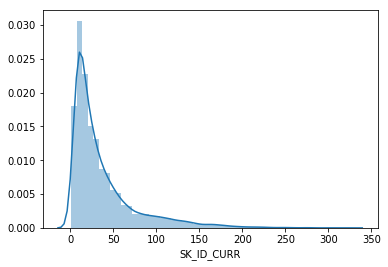

In [15]:
sns.distplot(value_counts)

In [16]:
installments_one = installments[installments['SK_ID_CURR']==328162]

In [17]:
installments_one.sort_values(['DAYS_INSTALMENT'],ascending=False).head(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
8768764,1249189,328162,0.0,145,-18.0,-20.0,13500.000,13500.000
10636162,1249189,328162,0.0,146,-20.0,-20.0,9000.000,9000.000
9049702,1710115,328162,1.0,23,-34.0,-34.0,59670.045,59670.045
10593207,1249189,328162,0.0,143,-49.0,-56.0,13500.000,13500.000
7692667,1249189,328162,0.0,144,-56.0,-56.0,9000.000,9000.000
9225287,1710115,328162,1.0,22,-64.0,-64.0,59670.045,59670.045
9981049,1249189,328162,0.0,141,-79.0,-81.0,13500.000,13500.000
9232247,1249189,328162,0.0,142,-81.0,-81.0,9000.000,9000.000
8720025,1710115,328162,1.0,21,-94.0,-123.0,59670.045,888.030
10401336,1710115,328162,1.0,21,-94.0,-92.0,59670.045,58782.015


In [18]:
# installments_ = installments[installments['SK_ID_CURR'].isin(positive_ID[:100])]
installments_ = installments.sample(10000)
installments_['instalment_paid_late_in_days'] = installments_['DAYS_ENTRY_PAYMENT'] - installments_['DAYS_INSTALMENT'] 
installments_['instalment_paid_late'] = (installments_['instalment_paid_late_in_days'] > 0).astype(int)
installments_['instalment_paid_over_amount'] = installments_['AMT_PAYMENT'] - installments_['AMT_INSTALMENT']
installments_['instalment_paid_over'] = (installments_['instalment_paid_over_amount'] > 0).astype(int)

In [19]:
def add_features(feature_name, aggs, features, feature_names, groupby):
    feature_names.extend(['{}_{}'.format(feature_name, agg) for agg in aggs])

    for agg in aggs:
        if agg == 'kurt':
            agg_func = kurtosis
        elif agg == 'iqr':
            agg_func = iqr
        else:
            agg_func = agg
        
        g = groupby[feature_name].agg(agg_func).reset_index().rename(index=str,
                                                                columns={feature_name: '{}_{}'.format(feature_name,
                                                                                                      agg)})
        features = features.merge(g, on='SK_ID_CURR', how='left')
    return features, feature_names


def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features

In [20]:
features = pd.DataFrame({'SK_ID_CURR':installments_['SK_ID_CURR'].unique()})
groupby = installments_.groupby(['SK_ID_CURR'])

In [21]:
installments_.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,instalment_paid_late_in_days,instalment_paid_late,instalment_paid_over_amount,instalment_paid_over
5165677,2744967,272574,1.0,19,-132.0,-138.0,12277.035,12277.035,-6.0,0,0.0,0
5610609,2379238,228512,0.0,13,-2561.0,-2561.0,1125.000,1125.000,0.0,0,0.0,0
7735185,1875294,329252,0.0,140,-517.0,-517.0,167.670,167.670,0.0,0,0.0,0
4137302,2000715,282975,1.0,11,-564.0,-560.0,8850.600,8256.600,4.0,1,-594.0,0
12359337,2665829,421391,1.0,12,-42.0,-71.0,2243.115,2243.115,-29.0,0,0.0,0


In [22]:
features.shape

(9719, 1)

In [23]:
installments_.shape

(10000, 12)

In [24]:
feature_names = []

features, feature_names = add_features('NUM_INSTALMENT_VERSION', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                     features, feature_names, groupby)

features, feature_names = add_features('instalment_paid_late_in_days', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                     features, feature_names, groupby)

features, feature_names = add_features('instalment_paid_late', ['sum','mean'],
                                     features, feature_names, groupby)

features, feature_names = add_features('instalment_paid_over_amount', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                     features, feature_names, groupby)

features, feature_names = add_features('instalment_paid_over', ['sum','mean'],
                                     features, feature_names, groupby)
    
display(features.head())

,SK_ID_CURR,NUM_INSTALMENT_VERSION_sum,NUM_INSTALMENT_VERSION_mean,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_std,NUM_INSTALMENT_VERSION_median,NUM_INSTALMENT_VERSION_skew,NUM_INSTALMENT_VERSION_kurt,NUM_INSTALMENT_VERSION_iqr,...,instalment_paid_over_amount_mean,instalment_paid_over_amount_max,instalment_paid_over_amount_min,instalment_paid_over_amount_std,instalment_paid_over_amount_median,instalment_paid_over_amount_skew,instalment_paid_over_amount_kurt,instalment_paid_over_amount_iqr,instalment_paid_over_sum,instalment_paid_over_mean
0,272574,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,0,0.0
1,228512,0.0,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,...,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,0,0.0
2,329252,0.0,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,...,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,0,0.0
3,282975,2.0,1.0,1.0,1.0,0.0,1.0,NaN,-3.0,0.0,...,-4539.6,-594.0,-8485.2,5579.921032,-4539.6,NaN,-2.0,3945.6,0,0.0
4,421391,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,0,0.0


In [27]:
display(features.tail(20))

,SK_ID_CURR,NUM_INSTALMENT_VERSION_sum,NUM_INSTALMENT_VERSION_mean,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_std,NUM_INSTALMENT_VERSION_median,NUM_INSTALMENT_VERSION_skew,NUM_INSTALMENT_VERSION_kurt,NUM_INSTALMENT_VERSION_iqr,...,instalment_paid_over_amount_mean,instalment_paid_over_amount_max,instalment_paid_over_amount_min,instalment_paid_over_amount_std,instalment_paid_over_amount_median,instalment_paid_over_amount_skew,instalment_paid_over_amount_kurt,instalment_paid_over_amount_iqr,instalment_paid_over_sum,instalment_paid_over_mean
9699,270590,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,0.00,0.00,0.00,NaN,0.00,NaN,-3.0,0.0,0,0.0
9700,401721,2.0,2.0,2.0,2.0,NaN,2.0,NaN,-3.0,0.0,...,0.00,0.00,0.00,NaN,0.00,NaN,-3.0,0.0,0,0.0
9701,450695,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,0.00,0.00,0.00,NaN,0.00,NaN,-3.0,0.0,0,0.0
9702,239475,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,0.00,0.00,0.00,NaN,0.00,NaN,-3.0,0.0,0,0.0
9703,140517,0.0,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,...,0.00,0.00,0.00,NaN,0.00,NaN,-3.0,0.0,0,0.0
9704,124692,2.0,2.0,2.0,2.0,NaN,2.0,NaN,-3.0,0.0,...,0.00,0.00,0.00,NaN,0.00,NaN,-3.0,0.0,0,0.0
9705,151201,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,0.00,0.00,0.00,NaN,0.00,NaN,-3.0,0.0,0,0.0
9706,109635,0.0,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,...,0.00,0.00,0.00,NaN,0.00,NaN,-3.0,0.0,0,0.0
9707,247613,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,0.00,0.00,0.00,NaN,0.00,NaN,-3.0,0.0,0,0.0
9708,424173,0.0,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,...,0.00,0.00,0.00,NaN,0.00,NaN,-3.0,0.0,0,0.0


In [28]:
features.to_csv("df_eda-installments",index=False)

In [25]:
# def last_k_instalment_features(gr, periods):
#     gr_ = gr.copy()
#     features = {}

#     for period in periods:
#         gr_period = gr_[gr_['DAYS_INSTALMENT'] >= (-1) * period]

#         features = add_features_in_group(features,gr_period, 'NUM_INSTALMENT_VERSION', 
#                                        ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
#                                          'last_{}_'.format(period))
        
#         features = add_features_in_group(features,gr_period, 'instalment_paid_late_in_days', 
#                                        ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
#                                          'last_{}_'.format(period))
#         features = add_features_in_group(features,gr_period ,'instalment_paid_late', 
#                                      ['count','mean'],
#                                          'last_{}_'.format(period))
#         features = add_features_in_group(features,gr_period ,'instalment_paid_over_amount', 
#                                        ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
#                                          'last_{}_'.format(period))
#         features = add_features_in_group(features,gr_period,'instalment_paid_over', 
#                                      ['count','mean'],
#                                          'last_{}_'.format(period))        
    
#     return features

In [26]:
# func = partial(last_k_instalment_features, periods=[60, 180, 360, 720, 1500, 10e24])

# g = parallel_apply(groupby, func, index_name='SK_ID_CURR',
#                    num_workers=16, chunk_size=10000).reset_index()
# features = features.merge(g, on='SK_ID_CURR', how='left')

# display(features.head())